## Trajectory

With GPS-enabled devices, it's easy to collect a large quantity of trajectory data, i.e. a connected series of points in 2D or 3D.  However, it's not so easy to plot large datasets with most plotting programs, and so people generally downsample the trajectories, which can hide important features of the data.  Here we show how to use [datashader](https://github.com/bokeh/datashader) to look at *all* the datapoints even for large datasets, faithfully displaying the data at the highest level, while revealing additional structure when examining small regions of the data.

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import datashader as ds
import datashader.transfer_functions as tf

### Create some fake data

Here we create a fake trajectory in a 2D space by calculating a random walk with momentum and then adding various perturbations:

1. a sine-based displacement of the x axis to simulate e.g. a mechanical problem
2. random noise on both x and y to simulate measurement uncertainty
3. a completely arbitrary bogus value at a fixed location, to simulate corrupted data

In [2]:
# Constants
np.random.seed(1)
n = 1000000 # Number of points
f = filter_width = 5000 # momentum or smoothing parameter, for a moving average filter

# filtered random walk
xs = np.convolve(np.random.normal(0, 0.1, size=n), np.ones(f)/f).cumsum()
ys = np.convolve(np.random.normal(0, 0.1, size=n), np.ones(f)/f).cumsum()

# Add "mechanical" wobble on the x axis
xs += 0.1*np.sin(0.1*np.array(range(n-1+f)))

# Add "measurement" noise
xs += np.random.normal(0, 0.005, size=n-1+f)
ys += np.random.normal(0, 0.005, size=n-1+f)

# Add a completely incorrect value
xs[int(len(xs)/2)] = 100
ys[int(len(xs)/2)] = 0

# Create a dataframe
df = pd.DataFrame(dict(x=xs,y=ys))

# Default plot ranges:
x_range = (xs.min(), xs.max())
y_range = (ys.min(), ys.max())

df.tail()

,x,y
1004994,65.164829,-105.064056
1004995,65.177603,-105.069781
1004996,65.190898,-105.071699
1004997,65.194054,-105.054657
1004998,65.204752,-105.073366


### Static Plots

With datashader, it's quick and easy to plot the entire 1-million-point dataset, without any downsampling:

In [3]:
def create_image(x_range=x_range, y_range=y_range, w=500, h=500):
    cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_height=h, plot_width=w)
    agg = cvs.line(df, 'x', 'y', agg=ds.any())
    return tf.shade(agg)

CPU times: user 868 ms, sys: 23.2 ms, total: 891 ms
Wall time: 593 ms


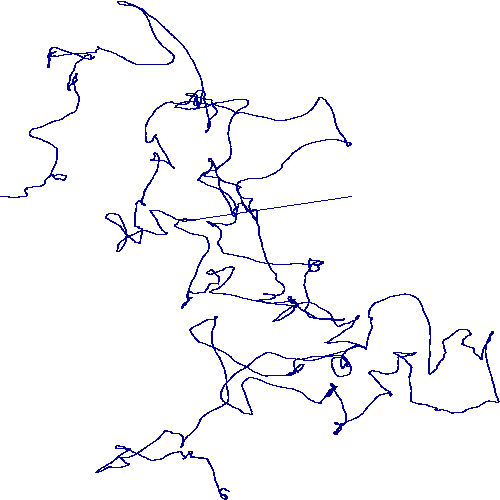

In [4]:
%time create_image()

Here you can immediately see the long straight line that results from the one stray value.  A single stray such value is very unlikely to be discovered in any downsampled plot, but is obvious here.

Similarly, the plot above suggests that the trajectory is relatively smooth, but if you zoom in further you can see the wobble that's not obvious at the high-level view:

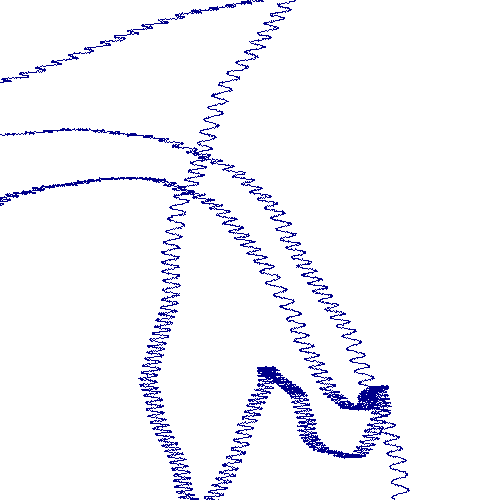

In [5]:
create_image(x_range=(95.0,101.0), y_range=(-61,-55))

Zooming in even further reveals the low-level noise displacing around each datapoint:

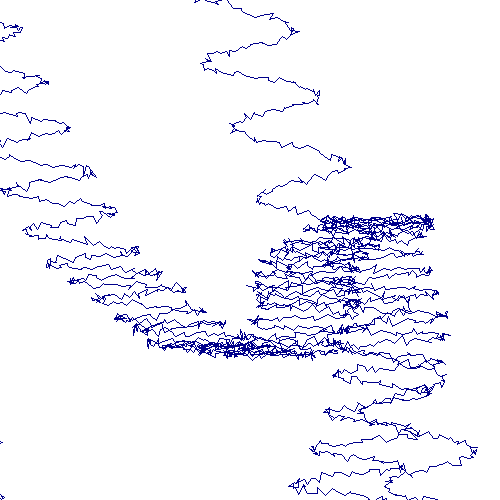

In [6]:
create_image(x_range=(98.8,99.8), y_range=(-60.2,-59.2))

Downsampling the dataset would cover up each of these problems.  If such data were then used for e.g. calculating total trajectory length, the result would be wildly incorrect -- the single incorrect reading would greatly increase the calculated length, as would the "measurement noise" and the added wobble.  Datashading makes the full dataset available for visual inspection, so that issues like this can be detected rather than being covered up by downsampling.


### Dynamic Plots

Specifying hard-coded ranges as above is awkward, so it's much more natural to simply zoom in interactively, which can be done by embedding the create_image function as a callback for a Bokeh plot.  If you are looking at a live, running version of this notebook and enable the scroll zoom tool in the upper right of the plot, you can select any region of the plot to examine more closely, with very fast updates as you explore even for large datasets.

In [7]:
from datashader.bokeh_ext import InteractiveImage
import bokeh.plotting as bp
bp.output_notebook()

def base_plot(tools='pan,wheel_zoom,reset'):
    p = bp.figure(tools=tools, plot_width=500, plot_height=500,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0)   
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    return p

p = base_plot()
InteractiveImage(p, create_image)

Loading BokehJS ...